# Negative L1 norm prior experiment

This code attempts to learn the 8D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 8

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 30000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1557.20263671875
iteration 0 loss 35.63762664794922


iteration 5000 loss 0.055143412202596664


iteration 10000 loss 0.040785498917102814


iteration 15000 loss 0.03499983623623848


iteration 20000 loss 0.028796501457691193


iteration 25000 loss 0.02489815279841423


iteration 30000 loss 0.02160738967359066


iteration 35000 loss 0.47908762097358704


iteration 40000 loss 0.016947193071246147


iteration 45000 loss 0.015011167153716087


iteration 50000 loss 0.013608560897409916


iteration 55000 loss 0.012339944951236248


iteration 60000 loss 0.016989829018712044


iteration 65000 loss 0.018240585923194885


iteration 70000 loss 0.07308568060398102


iteration 75000 loss 0.008909528143703938


iteration 80000 loss 0.00817496795207262


iteration 85000 loss 0.0077070994302630424


iteration 90000 loss 0.037525177001953125


iteration 95000 loss 0.006805870682001114


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.006518809124827385


iteration 105000 loss 0.006196756847202778


iteration 110000 loss 0.00587721960619092


iteration 115000 loss 0.0055565438233315945


iteration 120000 loss 0.005290620028972626


iteration 125000 loss 0.0050729489885270596


iteration 130000 loss 0.0048826211132109165


iteration 135000 loss 0.00471120048314333


iteration 140000 loss 0.004554549232125282


iteration 145000 loss 0.004410285037010908


iteration 150000 loss 0.004277706146240234


iteration 155000 loss 0.004155012313276529


iteration 160000 loss 0.004042779095470905


iteration 165000 loss 0.0039400141686201096


iteration 170000 loss 0.003843659069389105


iteration 175000 loss 0.003756137564778328


iteration 180000 loss 0.003673095256090164


iteration 185000 loss 0.003703607711941004


iteration 190000 loss 0.0035244429018348455


iteration 195000 loss 0.0034665425773710012


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.003391904290765524


iteration 205000 loss 0.0033654281869530678


iteration 210000 loss 0.003311132313683629


iteration 215000 loss 0.003258743789047003


iteration 220000 loss 0.0032095969654619694


iteration 225000 loss 0.003161898348480463


iteration 230000 loss 0.003119604429230094


iteration 235000 loss 0.0030771978199481964


iteration 240000 loss 0.003036026144400239


iteration 245000 loss 0.003009166568517685


iteration 250000 loss 0.0029601003043353558


iteration 255000 loss 0.0029247829224914312


iteration 260000 loss 0.0028917156159877777


iteration 265000 loss 0.0028589251451194286


iteration 270000 loss 0.002826507668942213


iteration 275000 loss 0.0027951588854193687


iteration 280000 loss 0.002765611745417118


iteration 285000 loss 0.0027376210782676935


iteration 290000 loss 0.0027097323909401894


iteration 295000 loss 0.002682969206944108


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0026564192958176136


iteration 305000 loss 0.00264912866987288


iteration 310000 loss 0.002624371787533164


iteration 315000 loss 0.0025999017525464296


iteration 320000 loss 0.002575875958427787


iteration 325000 loss 0.0025521975476294756


iteration 330000 loss 0.0025300809647887945


iteration 335000 loss 0.0025078975595533848


iteration 340000 loss 0.002486408920958638


iteration 345000 loss 0.0024655258748680353


iteration 350000 loss 0.00244492688216269


iteration 355000 loss 0.0024247996043413877


iteration 360000 loss 0.0024051498621702194


iteration 365000 loss 0.002385902451351285


iteration 370000 loss 0.002366976346820593


iteration 375000 loss 0.0023484446574002504


iteration 380000 loss 0.002329880138859153


iteration 385000 loss 0.0023120371624827385


iteration 390000 loss 0.0022942780051380396


iteration 395000 loss 0.002276913495734334


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0022597999777644873


iteration 405000 loss 0.0022554495371878147


iteration 410000 loss 0.002247624797746539


iteration 415000 loss 0.0022399332374334335


iteration 420000 loss 0.0022323643788695335


iteration 425000 loss 0.0022249016910791397


iteration 430000 loss 0.002217549365013838


iteration 435000 loss 0.0022103043738752604


iteration 440000 loss 0.0022031464613974094


iteration 445000 loss 0.002196058165282011


iteration 450000 loss 0.002189035527408123


iteration 455000 loss 0.002182080177590251


iteration 460000 loss 0.0021751862950623035


iteration 465000 loss 0.002168365055695176


iteration 470000 loss 0.002161636482924223


iteration 475000 loss 0.0021549768280237913


iteration 480000 loss 0.0021484079770743847


iteration 485000 loss 0.0021418894175440073


iteration 490000 loss 0.0021354369819164276


iteration 495000 loss 0.0021290406584739685


L2 loss -- Plot

loss 221.27996826171875


loss 155.95596313476562


loss 122.81317138671875


loss 101.62594604492188


loss 87.64485168457031


loss 78.85536193847656


loss 73.89698028564453


loss 71.48736572265625


loss 70.50050354003906


loss 70.16621398925781


loss 70.07569885253906


loss 70.05728149414062


loss 70.05470275878906


loss 70.05448913574219


loss 70.05447387695312


loss 70.05448150634766


loss 70.05448913574219


loss 70.05448913574219


loss 70.05448913574219


loss 70.05448150634766


loss 70.05448913574219


loss 70.05448913574219


loss 70.05448913574219


loss 70.05448150634766


loss 70.05448913574219


loss 70.05448913574219


loss 70.05448150634766


loss 70.05448150634766


loss 70.05448150634766


loss 70.05448913574219


loss 70.05448150634766


loss 70.05448150634766


loss 70.05448150634766


loss 70.05448150634766


loss 70.05448150634766


loss 70.05448150634766


loss 70.05448913574219


loss 70.05448150634766


loss 70.05448913574219


loss 70.05447387695312


final mse:  1.0582938969605493e-08
max, min: 3.010615 -3.056965
loss 221.27996826171875


loss 156.98985290527344


loss 124.534912109375


loss 103.66661071777344


loss 89.97207641601562


loss 81.49690246582031


loss 76.75397491455078


loss 74.40715026855469


loss 73.40515899658203


loss 73.04922485351562


loss 72.9495849609375


loss 72.92922973632812


loss 72.92647552490234


loss 72.92626953125


loss 72.92625427246094


loss 72.92625427246094


loss 72.9262466430664


loss 72.92625427246094


loss 72.92625427246094


loss 72.9262466430664


loss 72.9262466430664


loss 72.9262466430664


loss 72.92623901367188


loss 72.92625427246094


loss 72.9262466430664


loss 72.92625427246094


loss 72.92625427246094


loss 72.92623901367188


loss 72.92625427246094


loss 72.92626190185547


loss 72.92625427246094


loss 72.92625427246094


loss 72.92626190185547


loss 72.92625427246094


loss 72.92625427246094


loss 72.92625427246094


loss 72.9262466430664


loss 72.9262466430664


loss 72.92625427246094


loss 72.92625427246094


final mse:  8.38239522238382e-09
max, min: 3.022168 -3.0607727


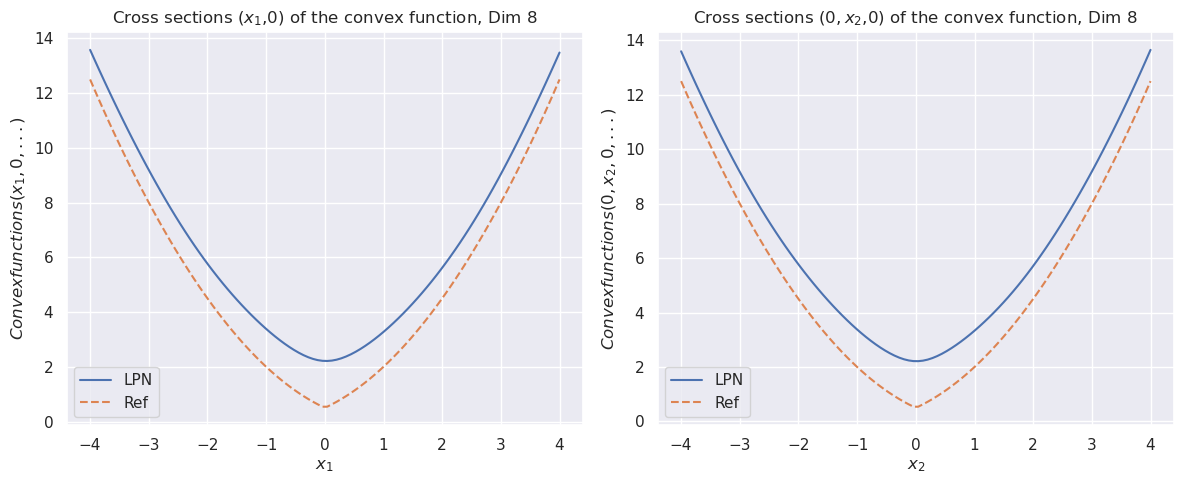

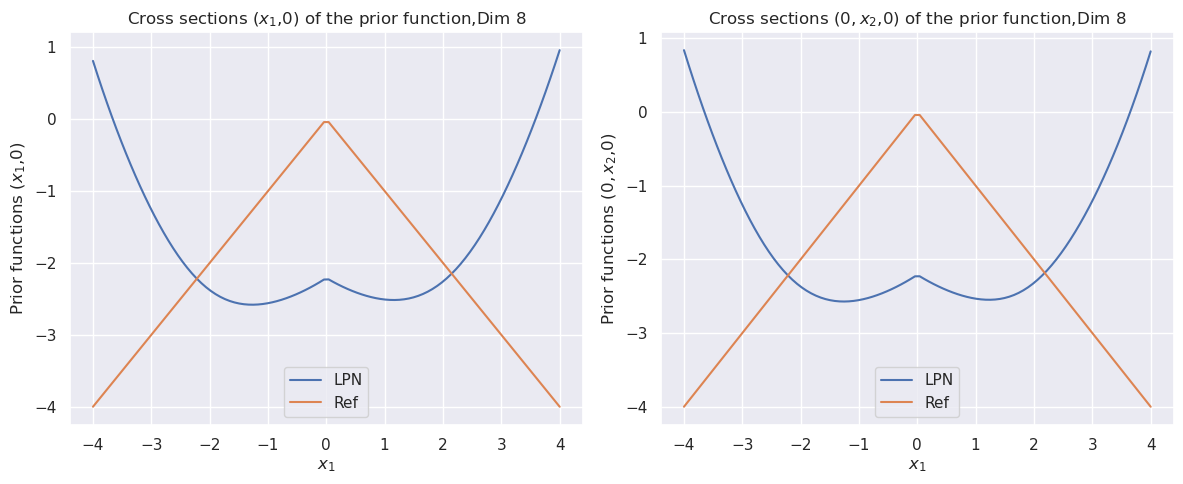

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 478.04986572265625
iteration 0 loss 1073.244873046875


iteration 5000 loss 0.30805426836013794


iteration 10000 loss 0.19817444682121277


iteration 15000 loss 0.13379141688346863


iteration 20000 loss 0.07749803364276886


iteration 25000 loss 0.05541526898741722


iteration 30000 loss 0.033745214343070984


iteration 35000 loss 0.020234284922480583


iteration 40000 loss 0.01326584629714489


iteration 45000 loss 0.00958348624408245


iteration 50000 loss 0.007421646732836962


iteration 55000 loss 0.006010213401168585


iteration 60000 loss 0.005455513019114733


iteration 65000 loss 0.004434479866176844


iteration 70000 loss 0.0038861259818077087


iteration 75000 loss 0.0035193359944969416


iteration 80000 loss 0.01596187986433506


iteration 85000 loss 0.0025562001392245293


iteration 90000 loss 0.0022874483838677406


iteration 95000 loss 0.002032187767326832


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0018094222759827971


iteration 105000 loss 0.001581360585987568


iteration 110000 loss 0.0013725097524002194


iteration 115000 loss 0.0012157874880358577


iteration 120000 loss 0.0010886907111853361


iteration 125000 loss 0.0010011028498411179


iteration 130000 loss 0.0009073668043129146


iteration 135000 loss 0.0008403805550187826


iteration 140000 loss 0.0008316654129885137


iteration 145000 loss 0.000738843809813261


iteration 150000 loss 0.0007005652296356857


iteration 155000 loss 0.0006669991998933256


iteration 160000 loss 0.0012263659154996276


iteration 165000 loss 0.0006129932589828968


iteration 170000 loss 0.0005903118290007114


iteration 175000 loss 0.0005704127252101898


iteration 180000 loss 0.0005524855223484337


iteration 185000 loss 0.0005364410462789237


iteration 190000 loss 0.0005216285935603082


iteration 195000 loss 0.0005083517753519118


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0004960637888871133


iteration 205000 loss 0.0004906755639240146


iteration 210000 loss 0.00047981084208004177


iteration 215000 loss 0.00046984798973426223


iteration 220000 loss 0.00046059489250183105


iteration 225000 loss 0.00045178915024735034


iteration 230000 loss 0.00044387023081071675


iteration 235000 loss 0.0004363891785033047


iteration 240000 loss 0.00042964579188264906


iteration 245000 loss 0.0004231974307913333


iteration 250000 loss 0.0004168981104157865


iteration 255000 loss 0.00041116212378256023


iteration 260000 loss 0.0004058050981257111


iteration 265000 loss 0.0004006741801276803


iteration 270000 loss 0.00039569861837662756


iteration 275000 loss 0.0003911909880116582


iteration 280000 loss 0.0003869017236866057


iteration 285000 loss 0.0003826241591013968


iteration 290000 loss 0.00037873731344006956


iteration 295000 loss 0.0003751064359676093


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.00037148065166547894


iteration 305000 loss 0.00036940156132914126


iteration 310000 loss 0.00036556090344674885


iteration 315000 loss 0.0003619635826908052


iteration 320000 loss 0.0003586728125810623


iteration 325000 loss 0.0003552091075107455


iteration 330000 loss 0.00035197543911635876


iteration 335000 loss 0.0003489507653284818


iteration 340000 loss 0.00034600449725985527


iteration 345000 loss 0.000343101448379457


iteration 350000 loss 0.0003403737209737301


iteration 355000 loss 0.00033819727832451463


iteration 360000 loss 0.0003356968518346548


iteration 365000 loss 0.00033348958822898567


iteration 370000 loss 0.0003314090718049556


iteration 375000 loss 0.0003291621687822044


iteration 380000 loss 0.0003268964937888086


iteration 385000 loss 0.00032495075720362365


iteration 390000 loss 0.00032296779681928456


iteration 395000 loss 0.0003210259019397199


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.00031904963543638587


iteration 405000 loss 0.0003186608955729753


iteration 410000 loss 0.00031711533665657043


iteration 415000 loss 0.00031545129604637623


iteration 420000 loss 0.00031385262263938785


iteration 425000 loss 0.00031230796594172716


iteration 430000 loss 0.00031080571352504194


iteration 435000 loss 0.00030935037648305297


iteration 440000 loss 0.0003079341840930283


iteration 445000 loss 0.0003065558848902583


iteration 450000 loss 0.0003052130341529846


iteration 455000 loss 0.00030390414758585393


iteration 460000 loss 0.00030263123335316777


iteration 465000 loss 0.00030138588044792414


iteration 470000 loss 0.0003001715231221169


iteration 475000 loss 0.00029898344655521214


iteration 480000 loss 0.0002978201664518565


iteration 485000 loss 0.0002966792380902916


iteration 490000 loss 0.00029555874061770737


iteration 495000 loss 0.0002944591687992215


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


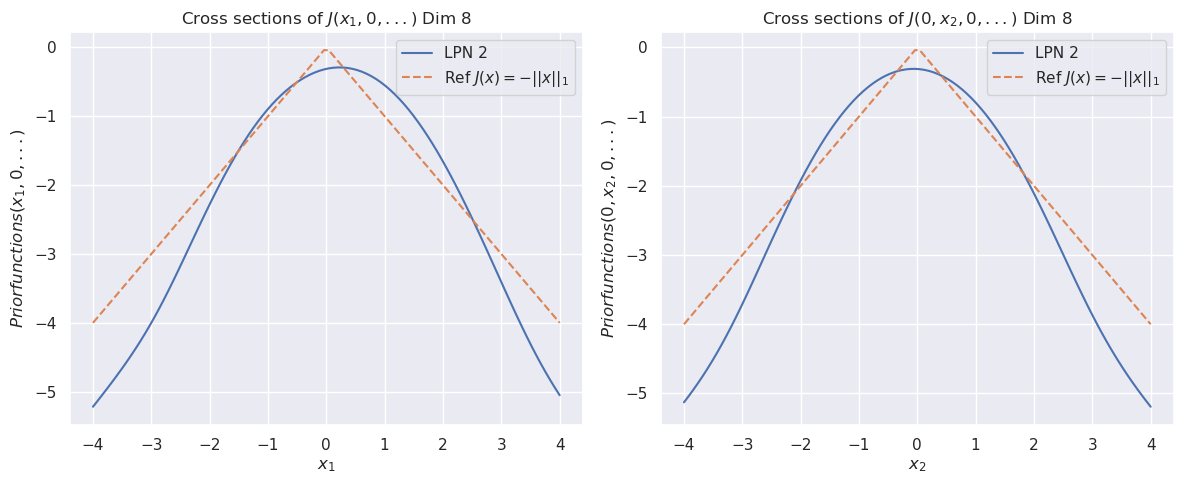

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)